# DenseNet 안면 Multi-Label (성별/나이) Classification

In [24]:
from keras.models import Sequential
"""Import from keras_preprocessing not from keras.preprocessing, because Keras may or maynot contain the features discussed here depending upon when you read this article, until the keras_preprocessed library is updated in Keras use the github version."""
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

### 데이터프레임 로드

In [25]:
df=pd.read_csv('data/FamilyData/Val/FamilyData_Val_DF.csv',index_col=0)
df.sample(20)

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
671,F0821_IND_M_45_-45_02.JPG,0,1,0,0,0,0,1,0,0
2404,F0875_IND_S_33_0_01.JPG,1,0,0,0,0,1,0,0,0
1693,F0853_IND_S_10_-90_02.JPG,1,0,0,1,0,0,0,0,0
318,F0811_IND_D_24_90_01.JPG,0,1,0,0,1,0,0,0,0
2336,F0873_IND_M_55_45_01.JPG,0,1,0,0,0,0,0,1,0
1439,F0845_IND_F_60_90_02.jpg,1,0,0,0,0,0,0,0,1
1725,F0854_IND_S_10_0_02.JPG,1,0,0,1,0,0,0,0,0
2664,F0883_IND_S_12_0_01.JPG,1,0,0,1,0,0,0,0,0
2430,F0876_IND_M_34_-45_01.JPG,0,1,0,0,0,1,0,0,0
1633,F0851_IND_M_36_-90_02.JPG,0,1,0,0,0,1,0,0,0


In [51]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(df, random_state=777, test_size=0.2)
train_df, val_df = train_test_split(train_df, random_state=777, test_size=0.2)

len(train_df) , len(val_df), len(test_df)

(2048, 512, 640)

In [52]:
train_df[:5]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
2371,F0874_IND_S_33_-45_02.JPG,1,0,0,0,0,1,0,0,0
1432,F0845_IND_F_60_-90_01.jpg,1,0,0,0,0,0,0,0,1
356,F0812_IND_S2_13_45_01.JPG,1,0,0,1,0,0,0,0,0
1501,F0847_IND_D_30_-45_02.jpg,0,1,0,0,0,1,0,0,0
22,F0801_IND_S_15_-90_01.JPG,1,0,0,1,0,0,0,0,0


In [53]:
val_df[:5]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
3017,F0894_IND_M_45_45_02.JPG,0,1,0,0,0,0,1,0,0
1039,F0833_IND_GM_69_90_02.JPG,0,1,0,0,0,0,0,0,1
2966,F0893_IND_D2_16_45_01.JPG,0,1,0,1,0,0,0,0,0
45,F0802_IND_M_44_0_02.JPG,0,1,0,0,0,0,1,0,0
527,F0816_IND_S_20_45_02.JPG,1,0,0,0,1,0,0,0,0


In [54]:
test_df[:5]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
186,F0807_IND_D_9_45_01.JPG,0,1,1,0,0,0,0,0,0
621,F0820_IND_M_54_-45_02.JPG,0,1,0,0,0,0,0,1,0
980,F0831_IND_S_13_-45_01.JPG,1,0,0,1,0,0,0,0,0
1648,F0852_IND_F_44_90_01.jpg,1,0,0,0,0,0,1,0,0
3193,F0900_IND_M_57_-90_02.JPG,0,1,0,0,0,0,0,1,0


In [55]:
columns= list(df.columns)[1:]
columns

['M', 'F', "0's", "10's", "20's", "30's", "40's", "50's", '60+']

### ImageGenerator 정의

In [56]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [57]:
preprocessed_data_path = 'D:/Preprocessed_Datasets(FamilyData_Val)'


train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=preprocessed_data_path,
    x_col="img_path",
    y_col=columns,
    batch_size=32,
    seed=777,
    shuffle=True,
    class_mode="other",
    target_size=(224,224))

Found 2048 validated image filenames.


In [58]:
valid_generator=test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=preprocessed_data_path,
    x_col="img_path",
    y_col=columns,
    batch_size=32,
    seed=777,
    shuffle=True,
    class_mode="other",
    target_size=(224,224))

Found 512 validated image filenames.


In [59]:
# test_generator은 batch_size 1개씩
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=preprocessed_data_path,
    x_col="img_path",
    y_col=columns,
    batch_size=1,
    seed=777,
    shuffle=False,
    class_mode="other",
    target_size=(224,224))

Found 640 validated image filenames.


### 모델 정의

In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization

# 레이어 추가 시
# include_top = False 
#model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
model_d=EfficientNetB0(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
output = model_d.output

x= GlobalAveragePooling2D()(output)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(9,activation='sigmoid')(x) #FC-layer

In [61]:
model=Model(inputs=model_d.input,outputs=preds)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  


 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_2[0][0]']     
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 225, 225, 3)          0         ['rescaling_5[0][0]']         
 2D)      

In [62]:
epochs = 5

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=valid_generator)

Epoch 1/5
64/64 [==============================] - 204s 3s/step - loss: 0.7458 - acc: 0.5078 - val_loss: 0.5674 - val_acc: 0.4863
Epoch 2/5
64/64 [==============================] - 197s 3s/step - loss: 0.4309 - acc: 0.8872 - val_loss: 0.4857 - val_acc: 0.4844
Epoch 3/5
64/64 [==============================] - 196s 3s/step - loss: 0.2772 - acc: 0.9336 - val_loss: 0.5232 - val_acc: 0.4785
Epoch 4/5
64/64 [==============================] - 196s 3s/step - loss: 0.2020 - acc: 0.9189 - val_loss: 0.5462 - val_acc: 0.5234
Epoch 5/5
64/64 [==============================] - 198s 3s/step - loss: 0.1486 - acc: 0.8916 - val_loss: 0.5741 - val_acc: 0.4883


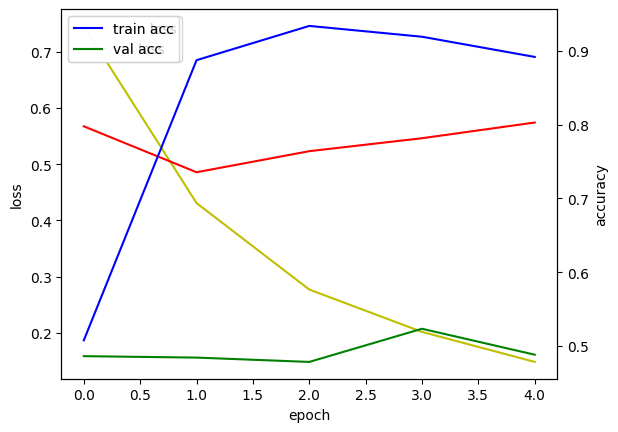

In [63]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [64]:
model.evaluate(test_generator)

640/640 [==============================] - 33s 52ms/step - loss: 0.5616 - acc: 0.5219


[0.5615891218185425, 0.5218750238418579]